# Evaluate Models on Puzzles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Xmaster6y/lczerolens/blob/main/docs/source/notebooks/features/evaluate-models-on-puzzles.ipynb)

## Setup

In [1]:
MODE = "local"  # "colab" | "colab-dev" | "local"

In [2]:
if MODE == "colab":
    !pip install -q lczerolens[hf]
elif MODE == "colab-dev":
    !rm -r lczerolens
    !git clone https://github.com/Xmaster6y/lczerolens -b main
    !pip install -q ./lczerolens --extra hf

## Load a Model

Load a leela network from file (already converted to `onnx`):

In [3]:
import torch
from lczerolens import LczeroModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

maia_1100 = LczeroModel.from_hf("lczerolens/maia-1100").to(device)
maia_1500 = LczeroModel.from_hf("lczerolens/maia-1500").to(device)
maia_1900 = LczeroModel.from_hf("lczerolens/maia-1900").to(device)

## Import a Puzzle Dataset

In [4]:
from datasets import load_dataset

dataset = load_dataset("lczerolens/lichess-puzzles", split="train")
dataset

Dataset({
    features: ['PuzzleId', 'FEN', 'Moves', 'Rating', 'RatingDeviation', 'Popularity', 'NbPlays', 'Themes', 'GameUrl', 'OpeningTags'],
    num_rows: 3974488
})

In [5]:
dataset.select_columns(["Rating", "RatingDeviation"])[:10]

{'Rating': [1913, 1429, 1419, 1112, 1556, 1311, 1428, 1590, 1501, 1941],
 'RatingDeviation': [75, 73, 75, 74, 81, 75, 79, 75, 75, 85]}

Expected moves:  ('e6e7', 'b2b1', 'b3c1', 'b1c1', 'h6c1')


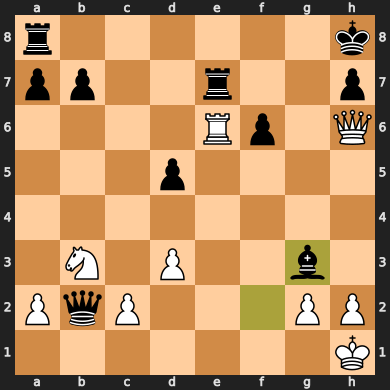

In [6]:
from lczerolens.data import PuzzleData

puzzle = PuzzleData.from_dict(dataset[0])
print("Expected moves: ", tuple(str(m) for m in puzzle.moves))
puzzle

## Evaluate a Sampler on a Puzzle

In [7]:
from lczerolens.sampling import PolicySampler, RandomSampler

maia_1100_sampler = PolicySampler(maia_1100)
maia_1500_sampler = PolicySampler(maia_1500)
maia_1900_sampler = PolicySampler(maia_1900)
random_sampler = RandomSampler()

m1_res = puzzle.evaluate(maia_1100_sampler)
m5_res = puzzle.evaluate(maia_1500_sampler)
m9_res = puzzle.evaluate(maia_1900_sampler)
r_res = puzzle.evaluate(random_sampler)
print(f"Maia 1100: {m1_res}\nMaia 1500: {m5_res}\nMaia 1900: {m9_res}\nRandom: {r_res}")

Maia 1100: {'score': 0.3333333333333333, 'perplexity': 2.9759849882221903, 'normalized_perplexity': 0.48293882044004194}
Maia 1500: {'score': 1.0, 'perplexity': 1.5176440275985872, 'normalized_perplexity': 0.2462812209863254}
Maia 1900: {'score': 0.6666666666666666, 'perplexity': 3.8677483433033424, 'normalized_perplexity': 0.6276529720634412}
Random: {'score': 0.3333333333333333, 'perplexity': 6.162240059750529, 'normalized_perplexity': 0.9999999857197207}


Two puzzle failure modes to distinguish:
- Some are failed due to the existance of an alternative solution.
- Interestingly some puzzles can be failed by "better" models, due to catstorphic forgetting on OOD boards (w.r.t. high level).

In general, the perplexity is a better indicator of performance than the success rate.

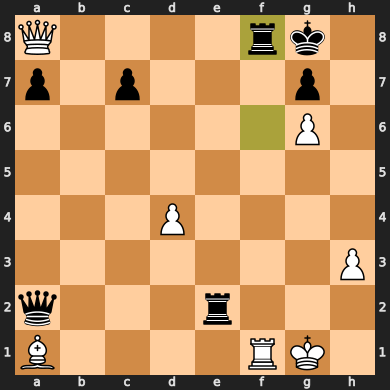

Maia 1100: {'score': 0.0, 'perplexity': 4.809047899171527, 'normalized_perplexity': 0.16582923790246645}
Maia 1500: {'score': 1.0, 'perplexity': 1.8551893878827406, 'normalized_perplexity': 0.06397204785802553}
Maia 1900: {'score': 1.0, 'perplexity': 2.36197235456554, 'normalized_perplexity': 0.08144732257122551}
Random: {'score': 0.0, 'perplexity': 29.00000010803342, 'normalized_perplexity': 1.0000000037252903}


In [8]:
p_alt = PuzzleData.from_dict(dataset[140])
display(p_alt)

m1_res = p_alt.evaluate(maia_1100_sampler)
m5_res = p_alt.evaluate(maia_1500_sampler)
m9_res = p_alt.evaluate(maia_1900_sampler)
r_res = p_alt.evaluate(random_sampler)
print(f"Maia 1100: {m1_res}\nMaia 1500: {m5_res}\nMaia 1900: {m9_res}\nRandom: {r_res}")

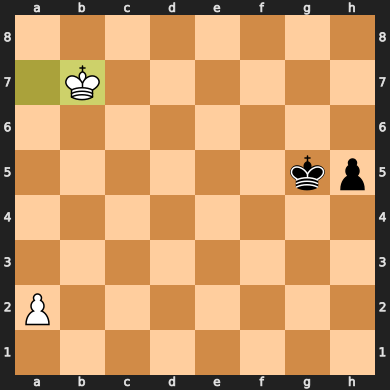

Maia 1100: {'score': 0.75, 'perplexity': 1.1047824116820508, 'normalized_perplexity': 0.12116461849847746}
Maia 1500: {'score': 0.75, 'perplexity': 1.0487962013962442, 'normalized_perplexity': 0.11502445212840713}
Maia 1900: {'score': 0.75, 'perplexity': 1.1111460698452358, 'normalized_perplexity': 0.12186253892646749}
Random: {'score': 0.25, 'perplexity': 9.118028142900856, 'normalized_perplexity': 0.9999999906867744}


In [9]:
p_fail = PuzzleData.from_dict(dataset[1966])
display(p_fail)

m1_res = p_fail.evaluate(maia_1100_sampler)
m5_res = p_fail.evaluate(maia_1500_sampler)
m9_res = p_fail.evaluate(maia_1900_sampler)
r_res = p_fail.evaluate(random_sampler)
print(f"Maia 1100: {m1_res}\nMaia 1500: {m5_res}\nMaia 1900: {m9_res}\nRandom: {r_res}")

## Scale Evaluation

In [10]:
def puzzle_generator(dataset, lim=10_000):
    i = 0
    for d in dataset:
        i += 1
        if i > lim:
            break
        yield PuzzleData.from_dict(d)

In [11]:
res_gen = PuzzleData.evaluate_multiple(puzzle_generator(dataset), maia_1100_sampler, batch_size=40_000)

In [12]:
res_list = list(res_gen)
res_list[:10]

[{'score': 0.3333333333333333,
  'perplexity': 2.9759698893779407,
  'normalized_perplexity': 0.4829363702200103},
 {'score': 0.5,
  'perplexity': 4.820220835680495,
  'normalized_perplexity': 0.5933281695135574},
 {'score': 1.0,
  'perplexity': 1.6111290723279195,
  'normalized_perplexity': 0.10399793442861062},
 {'score': 1.0,
  'perplexity': 1.7375325243615212,
  'normalized_perplexity': 0.07000718044357511},
 {'score': 1.0,
  'perplexity': 1.177018491802616,
  'normalized_perplexity': 0.18810251020070143},
 {'score': 0.5,
  'perplexity': 2.920277688886903,
  'normalized_perplexity': 0.11021877868171656},
 {'score': 0.5,
  'perplexity': 2.468727174587017,
  'normalized_perplexity': 0.06794947913007711},
 {'score': 0.5,
  'perplexity': 5.543904877248917,
  'normalized_perplexity': 0.1278606315901418},
 {'score': 1.0,
  'perplexity': 1.0126595806986676,
  'normalized_perplexity': 0.1378055142140278},
 {'score': 0.5,
  'perplexity': 4.498476410170166,
  'normalized_perplexity': 0.11842

## Plot the Results

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl

mpl.rcParams["mathtext.fontset"] = "stix"
# Use Matplotlib-bundled STIX font family to avoid missing font errors
mpl.rcParams["font.family"] = "STIXGeneral"
sns.set_theme(style="darkgrid")


def make_df(res):
    records = []
    columns = None
    for idx, (m, puzzle) in enumerate(zip(res, puzzle_generator(dataset))):
        p_dict = puzzle.__dict__
        if m["score"] == 0:
            result = "fail"
        elif m["score"] == 1:
            result = "success"
        else:
            result = "partial"
        if columns is None:
            columns = ["idx", "result"] + [k for k in m.keys()] + [k for k in p_dict.keys()]
        records.append({"idx": idx, "result": result, **m, **p_dict})

    return pd.DataFrame(records, columns=columns)


PALETTE = {"fail": "red", "success": "green", "partial": "blue"}

In [14]:
df_1 = make_df(res_list)

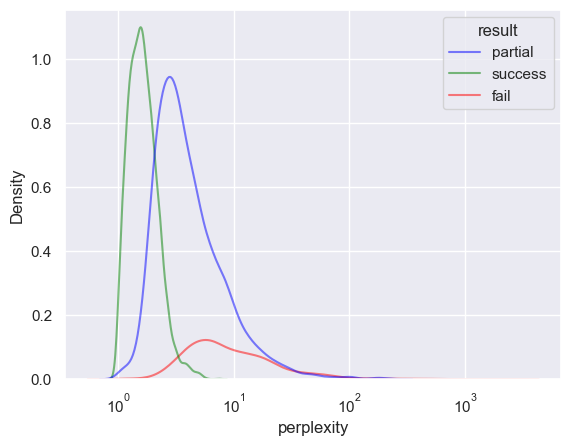

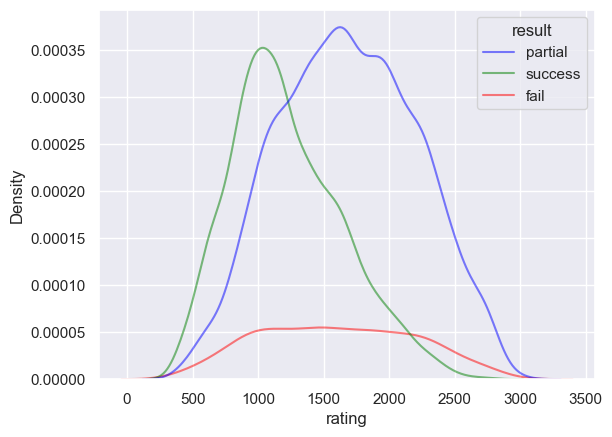

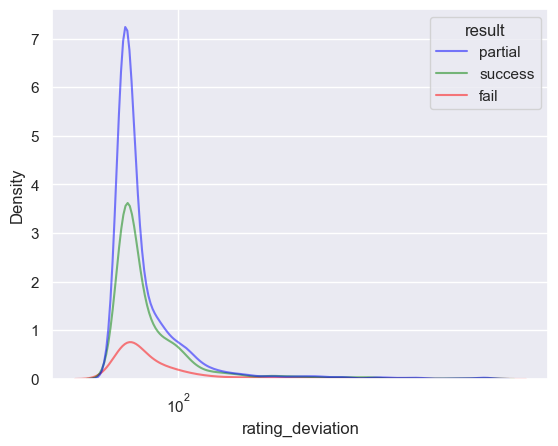

In [15]:
sns.kdeplot(df_1, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE, levels=20)
plt.show()
sns.kdeplot(df_1, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE, levels=20)
plt.show()
sns.kdeplot(df_1, x="rating_deviation", hue="result", log_scale=True, alpha=0.5, palette=PALETTE, levels=20)
plt.show()

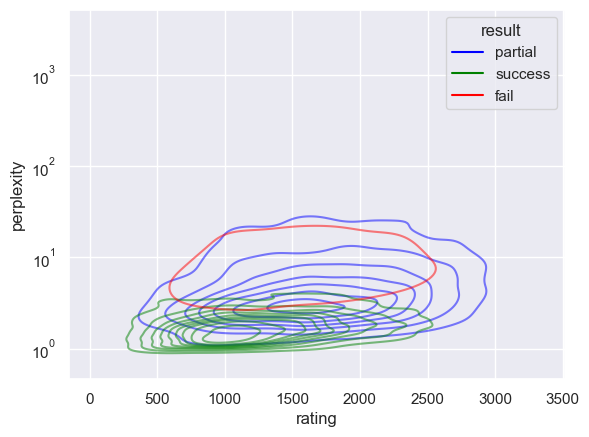

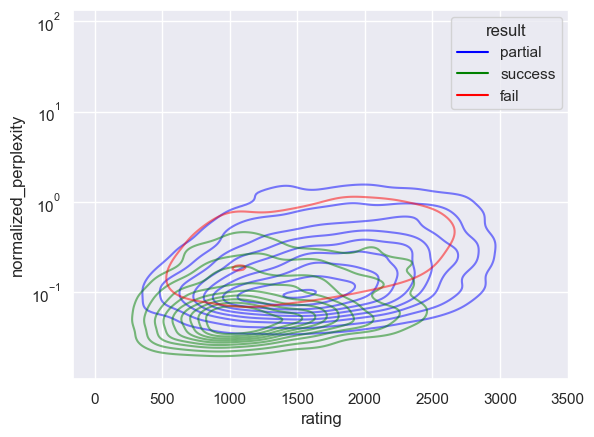

In [16]:
sns.kdeplot(
    df_1, x="rating", y="perplexity", hue="result", log_scale=(False, True), alpha=0.5, palette=PALETTE, levels=10
)
plt.show()
sns.kdeplot(
    df_1,
    x="rating",
    y="normalized_perplexity",
    hue="result",
    log_scale=(False, True),
    alpha=0.5,
    palette=PALETTE,
    levels=10,
)
plt.show()

## Compare Models

In [17]:
res_gen_5 = PuzzleData.evaluate_multiple(puzzle_generator(dataset), maia_1500_sampler, batch_size=40_000)
df_5 = make_df(res_gen_5)

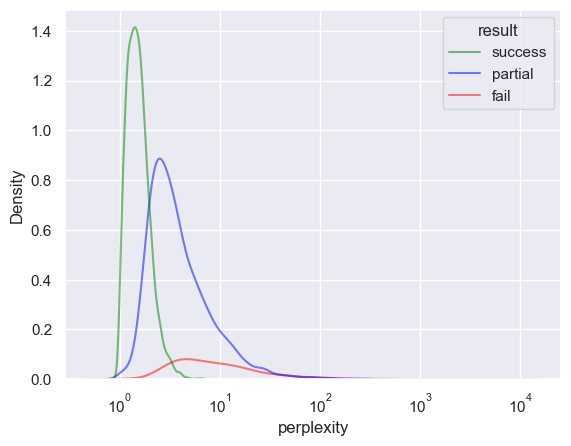

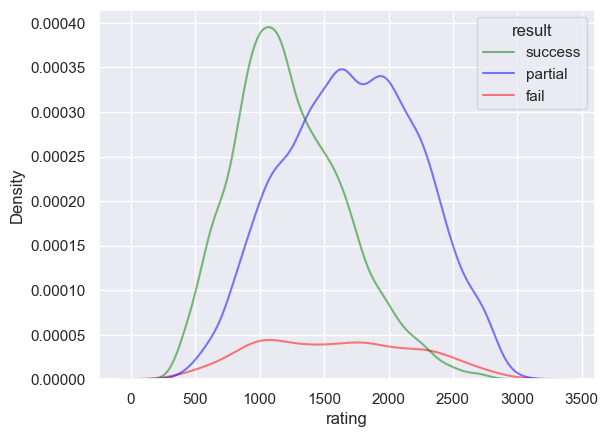

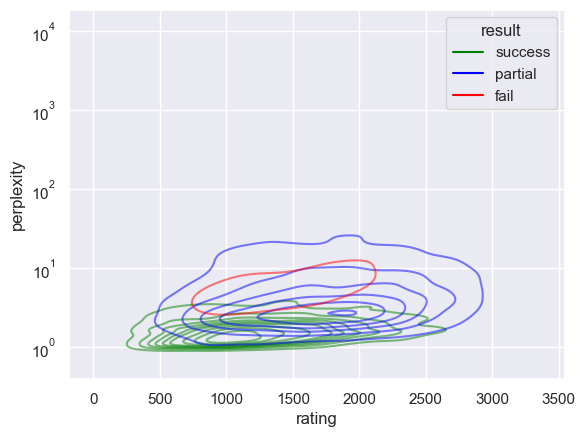

In [18]:
sns.kdeplot(df_5, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(df_5, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(
    df_5, x="rating", y="perplexity", hue="result", log_scale=(False, True), alpha=0.5, palette=PALETTE, levels=10
)
plt.show()

In [19]:
res_gen_9 = PuzzleData.evaluate_multiple(puzzle_generator(dataset), maia_1900_sampler, batch_size=40_000)
df_9 = make_df(res_gen_9)

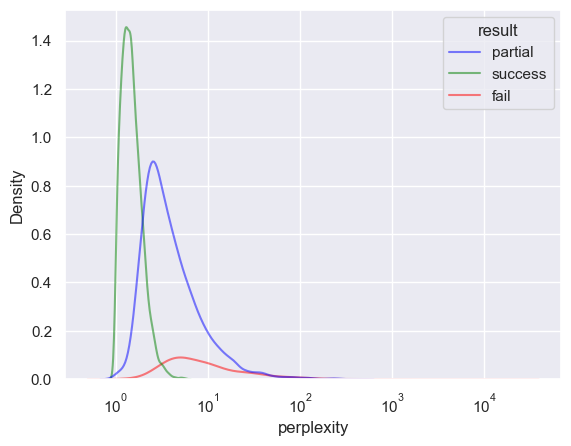

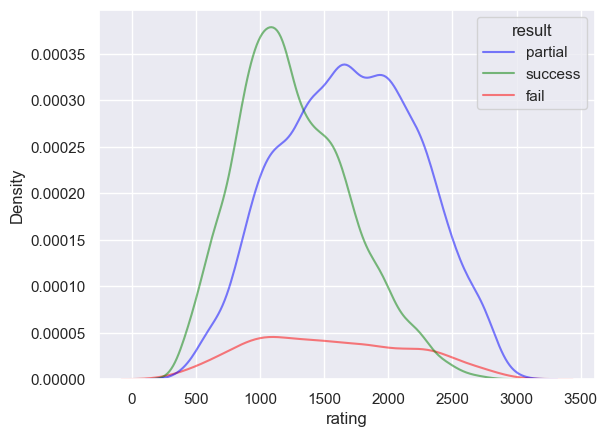

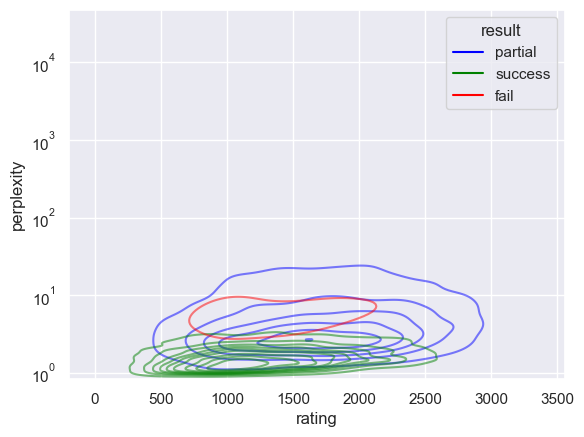

In [20]:
sns.kdeplot(df_9, x="perplexity", hue="result", log_scale=True, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(df_9, x="rating", hue="result", log_scale=False, alpha=0.5, palette=PALETTE)
plt.show()
sns.kdeplot(
    df_9, x="rating", y="perplexity", hue="result", log_scale=(False, True), alpha=0.5, palette=PALETTE, levels=10
)
plt.show()

In [21]:
# Count the number of 'success', 'partial', and 'fail' results for each DataFrame
for name, df in [("df_1", df_1), ("df_5", df_5), ("df_9", df_9)]:
    counts = df["result"].value_counts()
    print(f"{name} result counts:")
    print(counts)
    print()

df_1 result counts:
result
partial    5488
success    3502
fail       1010
Name: count, dtype: int64

df_5 result counts:
result
partial    5171
success    4052
fail        777
Name: count, dtype: int64

df_9 result counts:
result
partial    5192
success    4012
fail        796
Name: count, dtype: int64



## Explore Failures

In [22]:
easy_fails = df_9[(df_9["result"] == "fail") & (df_9["rating"] < 600)]
len(easy_fails)

32

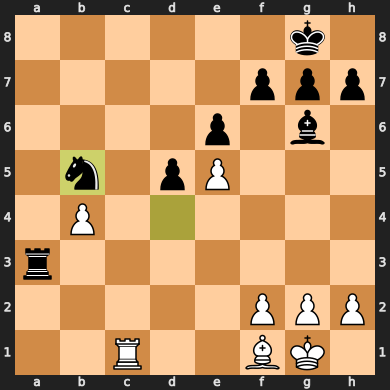

Expected moves:  ('e6e7', 'b2b1', 'b3c1', 'b1c1', 'h6c1')
Maia 1100: {'score': 0.0, 'perplexity': 5.051555873178584, 'normalized_perplexity': 0.229616176053572}
Maia 1500: {'score': 0.0, 'perplexity': 4.082437059690364, 'normalized_perplexity': 0.18556532089501657}
Maia 1900: {'score': 0.0, 'perplexity': 7.494882598287819, 'normalized_perplexity': 0.3406764817403554}
Random: {'score': 1.0, 'perplexity': 21.999999344348925, 'normalized_perplexity': 0.9999999701976785}


In [23]:
row = easy_fails.iloc[0]
p_idx = int(row["idx"])
p = PuzzleData.from_dict(dataset[p_idx])
display(p)

print("Expected moves: ", tuple(str(m) for m in puzzle.moves))
m1_res = p.evaluate(maia_1100_sampler)
m5_res = p.evaluate(maia_1500_sampler)
m9_res = p.evaluate(maia_1900_sampler)
r_res = p.evaluate(random_sampler)
print(f"Maia 1100: {m1_res}\nMaia 1500: {m5_res}\nMaia 1900: {m9_res}\nRandom: {r_res}")